In [1]:
import seaborn as sns


tbd

In [2]:
from pathlib import Path
import json

# Root folder where your nested folders are located
root_folder = Path("../data/dataset_sw+fw")  # replace with your top-level folder
#root_folder = Path("../cvelistV5/cves/2016")
#root_folder = Path("../cvelistV5/cves/2017")  
#root_folder = Path("../cvelistV5/cves/2018")  
#root_folder = Path("../cvelistV5/cves/2019")
#root_folder = Path("../cvelistV5/cves/2020")
#root_folder = Path("../cvelistV5/cves/2021")
#root_folder = Path("../cvelistV5/cves/2022")
#root_folder = Path("../cvelistV5/cves/2023")
#root_folder = Path("../cvelistV5/cves/2024")
#root_folder = Path("../cvelistV5/cves/2025")

#root_folder = Path("../cvelistV5/cves/")    




# Recursively find all JSON files
json_files = list(root_folder.rglob("*.json"))

print(f"Found {len(json_files)} JSON files.")

# Example: load each JSON file
for file_path in json_files:
    with open(file_path) as f:
        data = json.load(f)
        # Now you can use 'data', e.g., classify IoT type
        print(f"Loaded {file_path.name}")


Found 892 JSON files.
Loaded CVE-2022-32259.json
Loaded CVE-2019-4640.json
Loaded CVE-2022-38101.json
Loaded CVE-2019-1880.json
Loaded CVE-2025-57804.json
Loaded CVE-2022-38625.json
Loaded CVE-2025-43522.json
Loaded CVE-2023-45779.json
Loaded CVE-2024-52537.json
Loaded CVE-2020-0996.json
Loaded CVE-2018-19234.json
Loaded CVE-2024-12577.json
Loaded CVE-2020-2032.json
Loaded CVE-2024-36282.json
Loaded CVE-2017-8665.json
Loaded CVE-2022-25291.json
Loaded CVE-2021-36021.json
Loaded CVE-2024-48775.json
Loaded CVE-2024-52935.json
Loaded CVE-2021-22790.json
Loaded CVE-2021-3485.json
Loaded CVE-2021-28191.json
Loaded CVE-2023-0392.json
Loaded CVE-2025-54596.json
Loaded CVE-2020-10831.json
Loaded CVE-2025-29084.json
Loaded CVE-2018-6221.json
Loaded CVE-2021-33090.json
Loaded CVE-2025-30199.json
Loaded CVE-2022-34471.json
Loaded CVE-2023-30702.json
Loaded CVE-2023-7005.json
Loaded CVE-2021-1426.json
Loaded CVE-2016-4741.json
Loaded CVE-2022-24644.json
Loaded CVE-2021-46442.json
Loaded CVE-2021-3

Prepare the training dataset (important step)
Use ONLY the CVE description text

In [3]:
def extract_description(cve_json):
    try:
        descs = cve_json["containers"]["cna"].get("descriptions", [])
        if descs:
            return descs[0]["value"]
    except KeyError:
        pass
    return ""


Showing  random CVE description samples:


In [4]:
# Preview sample CVE descriptions to ensure extraction works
import random

sample_files = random.sample(json_files, min(5, len(json_files)))  # pick up to 5 random files

print(f"Showing {len(sample_files)} random CVE description samples:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    desc = extract_description(cve_data)
    print(f"{path.name}: {desc[:300]}")
    #print(f"Description: {desc[:300]}")  # show first 300 chars for brevity
    #print("-" * 80)


Showing 5 random CVE description samples:

CVE-2021-33879.json: Tencent GameLoop before 4.1.21.90 downloaded updates over an insecure HTTP connection. A malicious attacker in an MITM position could spoof the contents of an XML document describing an update package, replacing a download URL with one pointing to an arbitrary Windows executable. Because the only in
CVE-2025-0626.json: The "monitor" binary in the firmware of the affected product attempts to mount to a hard-coded, routable IP address, bypassing existing device network settings to do so. The function also enables the network interface of the device if it is disabled. The function is triggered by attempting to update
CVE-2022-34458.json: 
Dell Command | Update, Dell Update, and Alienware Update versions prior to 4.7 contain a Exposure of Sensitive System Information to an Unauthorized Control Sphere vulnerability in download operation component. A local malicious user could potentially exploit this vulnerability leading to th



Define the label space (fixed & explicit)

In [5]:

LABELS = [
    "Home",
    "SCADA",
    "Enterprise",
    "Mobile",
    "PC",
    "Other"
]

label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}


Convert rule-based output to label ID

In [6]:
def normalize_label(rule_label):
    if "Home" in rule_label:
        return "Home"
    if "SCADA" in rule_label:
        return "SCADA"
    if "Enterprise" in rule_label:
        return "Enterprise"
    if "Mobile" in rule_label:
        return "Mobile"
    if "PC" in rule_label:
        return "PC"
    return "Other"


 Smart Rule-Based with Word Context

In [7]:
# ==================== 4.  RULE-BASED CLASSIFIER ====================
import re
def classify_cve_iot_category(cve):
    """Enhanced rule-based classifier with better keyword coverage"""
    desc = extract_description(cve).lower()
    
    # Expanded keywords based on actual CVE patterns
    patterns = {
        "Home": [
            # Smart home devices
            r"smart\s+(home|thermostat|bulb|lock|speaker|tv|plug|camera|doorbell)",
            r"iot\s+device",
            r"connected\s+device",
            r"home\s+automation",
            # Network devices (home/SOHO)
            r"\b(router|wifi|wireless)\s+(router|access\s+point|device)",
            r"\b(tplink|d-link|asus|netgear|linksys|nest|ring|arlo|wyze|roku)\b",
            # Home security
            r"security\s+camera",
            r"ip\s+camera",
            r"baby\s+monitor",
            # Home entertainment
            r"smart\s+tv",
            r"streaming\s+device",
            r"gaming\s+console",
            # Keywords from your data
            r"\b(soho|home\s+router)\b"
            ##
            r"home\s+camera",
            r"home\s+security\s+camera",
            r"home\s+surveillance",
            r"yi",
            r"TP-Link "


        ],
        
        "SCADA": [
            # Industrial systems
            r"\b(scada|ics|plc|hmi|rtu|dcs)\b",
            r"industrial\s+control",
            r"process\s+control",
            r"supervisory\s+control",
            # Critical infrastructure
            r"power\s+(grid|plant|station)",
            r"water\s+treatment",
            r"\b(oil|gas)\s+.*\s+(plant|refinery|pipeline)",
            # Medical devices
            r"medical\s+device",
            r"patient\s+monitor",
            r"hospital\s+equipment",
            # Manufacturing
            r"\b(manufacturing|factory|plant)\b",
            # Automotive
            r"\b(automotive|vehicle|car)\b",
            r"engine\s+control"
        ],
        
        "Enterprise": [
            # Enterprise context
            r"enterprise\s+(network|system|software|application)",
            r"business\s+(network|application)",
            r"corporate\s+(network|environment)",
            # Cloud and servers
            r"cloud\s+(service|infrastructure|platform)",
            r"data\s+center",
            r"server\s+(software|application|side|hardware)",
            # Networking equipment
            r"\b(switch|firewall|vpn|load\s+balancer)\b",
            # Specific enterprise brands
            r"\b(cisco|juniper|paloalto|fortinet|vmware|oracle|sap|microsoft\s+server)\b",
            # Storage
            r"storage\s+system",
            r"\b(nas|san)\b",
            ##
            r"local area",
            r"Operational Technology",
            r"Information Technology",

        ],
        
        "Mobile": [
            # Mobile devices
            r"\b(android|ios|iphone|ipad|smartphone|tablet)\b",
            r"mobile\s+(device|phone|application|app|os)",
            # Mobile context
            r"google\s+play",
            r"app\s+store",
            # Wearables
            r"\b(smartwatch|wearable|fitness\s+tracker)\b",
            # Mobile networks
            r"\b(5g|lte|cellular)\b"
        ],
        
        "PC": [
            # Personal computers
            r"\b(pc|computer|desktop|laptop|notebook)\b",
            r"personal\s+computer",
            # Operating systems
            r"\b(windows|linux|macos|ubuntu|debian|centos|red\s+hat)\b",
            r"operating\s+system",
            # PC components
            r"\b(bios|uefi|cpu|gpu|ram|ssd|hard\s+drive|motherboard)\b",
            # PC software
            r"\b(microsoft\s+office|adobe|antivirus|browser)\b",
            # Specific terms from your data
            r"\b(intel\s+nuc|chrome\s+os)\b",
            ##
            r"mac"
        ]
    }


    # Score categories
    scores = {}
    for category, regex_list in patterns.items():
        score = 0
        for pattern in regex_list:
            #matches = re.findall(pattern, desc)
            # Make search case-insensitive
            matches = re.findall(pattern, desc, flags=re.IGNORECASE)
            if matches:
                # Multi-word patterns get higher weight
                if "\\s" in pattern:
                    score += len(matches) * 3
                else:
                    score += len(matches) * 2
        if score > 0:
            scores[category] = score
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:  # Lower threshold to catch more cases
            return best_category
    
    return "Other"

##### Building dataset with rule-based classification...

In [8]:
# ==================== 5. BUILD DATASET ====================
from datasets import Dataset

texts = []
labels = []
rule_predictions = []

for json_file in json_files:
    with open(json_file) as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue


    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    # Use improved classifier
    rule_label = classify_cve_iot_category(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    rule_predictions.append(rule_label)

# Create dataset
dataset = Dataset.from_dict({
    "text": texts,
    "label": labels
})


In [9]:
# ==================== 6. PRINT CLASS DISTRIBUTION ====================
import pandas as pd

print("\n" + "="*70)
print(" Rule-Based Classification Distribution Based on Discription Only")
print("="*70)

# Desired fixed class order
CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution
dist_counts = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts.columns = ["IoT_Class", "Count"]

# Add percentage
dist_counts["Percentage"] = (dist_counts["Count"] / len(dataset) * 100).round(1)

# Print formatted distribution
print("\n IoT Class Distribution:")
print("-" * 35)

for idx, row in dist_counts.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")



 Rule-Based Classification Distribution Based on Discription Only

 IoT Class Distribution:
-----------------------------------
 1  Home               80 (9.0%)
 2  SCADA              17 (1.9%)
 3  Enterprise         49 (5.5%)
 4  Mobile             24 (2.7%)
 5  PC                206 (23.1%)
 6  Other             516 (57.8%)


/tmp/ipykernel_331937/487175815.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


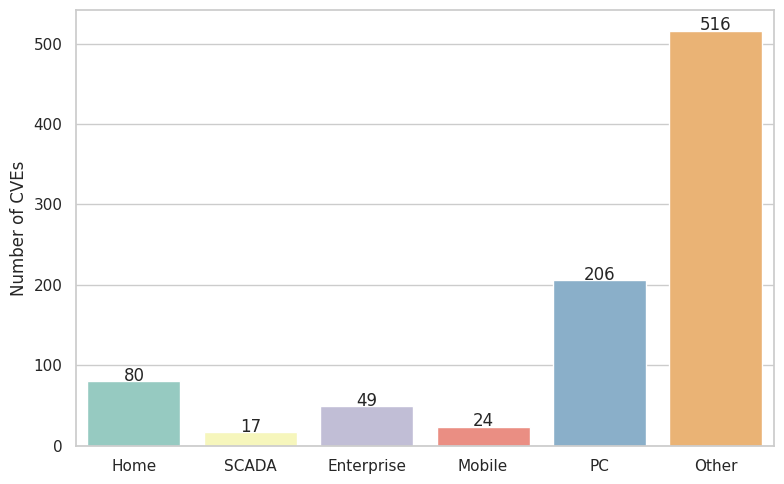

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Define colors for each bar
colors = sns.color_palette("Set3", len(dist_counts))

# Create barplot
ax = sns.barplot(
    data=dist_counts,
    x="IoT_Class",
    y="Count",
    order=dist_counts["IoT_Class"],  # keep the order
    palette=colors
)

# Add numbers on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,  # center of the bar
        y=height + 0.5,  # slightly above the bar
        s=f'{int(height)}',  # text to show
        ha='center'
    )

#plt.title("Number of CVEs per IoT Class")
plt.xlabel("")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('iot_cves_plot_des.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [11]:
#dist_counts = pd.DataFrame()  # empty, reset for plot 


In [12]:
# ====================   RANDOM DESCRIPTIONS PER CLASS ====================
print(" 3 Random CVE Descriptions per IoT Class")
print("="*50)

for idx, row in dist_counts.iterrows():
    cls = row["IoT_Class"]
    indices = [i for i, l in enumerate(rule_predictions) if l == cls]

    if not indices:
        continue

    random.shuffle(indices)
    print(f"\n{idx+1}. {cls.upper()}")

    for i in indices[:3]:
        cve_name = Path(json_files[i]).name

        with open(json_files[i], "r", encoding="utf-8") as f:
            desc = extract_description(json.load(f))

        print(f" {cve_name}: {desc[:150]}{'...' if len(desc) > 150 else ''}")

 3 Random CVE Descriptions per IoT Class

1. HOME
 CVE-2022-46914.json: An issue in the firmware update process of TP-LINK TL-WA801N / TL-WA801ND V1 v3.12.16 and earlier allows attackers to execute arbitrary code or cause ...
 CVE-2018-3890.json: An exploitable code execution vulnerability exists in the firmware update functionality of Yi Home Camera 27US 1.8.7.0D. A specially crafted file can ...
 CVE-2025-24918.json: Improper link resolution before file access ('link following') for some Intel(R) Server Configuration Utility software and Intel(R) Server Firmware Up...

2. SCADA
 CVE-2022-29957.json: The Emerson DeltaV Distributed Control System (DCS) through 2022-04-29 mishandles authentication. It utilizes several proprietary protocols for a wide...
 CVE-2019-14926.json: An issue was discovered on Mitsubishi Electric Europe B.V. ME-RTU devices through 2.02 and INEA ME-RTU devices through 3.0. Hard-coded SSH keys allow ...
 CVE-2018-18203.json: A vulnerability in the update mechanism

### Adding Vendor and product
##### i think adding keywords from the vendors and products names would improve my rule-based

In [13]:
def extract_vendor_product(cve_json):
    """Extract vendor and product information from CVE JSON"""
    vendor = "Unknown"
    product = "Unknown"
    
    try:
        # Try to get from affected section in cna
        affected = cve_json["containers"]["cna"].get("affected", [])
        if affected:
            vendor = affected[0].get("vendor", "Unknown")
            product = affected[0].get("product", "Unknown")
    except (KeyError, IndexError):
        pass
    
    # Also check adp section if not found
    if vendor == "Unknown":
        try:
            adp = cve_json["containers"].get("adp", [])
            for item in adp:
                affected = item.get("affected", [])
                if affected:
                    vendor = affected[0].get("vendor", "Unknown")
                    product = affected[0].get("product", "Unknown")
                    if vendor != "Unknown":
                        break
        except (KeyError, IndexError):
            pass
    
    return vendor, product

reve

In [14]:
# ==================== 3. PREVIEW DATA WITH VENDOR/PRODUCT INFO ====================
print("\n" + "="*50)
print("Previewing CVE data with vendor/product information")
print("="*50)

import random
sample_files = random.sample(json_files, min(100, len(json_files)))

print(f"\nShowing {len(sample_files)} random CVE samples with vendor/product info:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    
    desc = extract_description(cve_data)
    vendor, product = extract_vendor_product(cve_data)
    
    print(f" {path.name}:")
    print(f"   Vendor: {vendor}")
    print(f"   Product: {product}")
    print(f"   Description: {desc[:150]}...")
    print("-" * 80)



Previewing CVE data with vendor/product information

Showing 100 random CVE samples with vendor/product info:

 CVE-2022-36173.json:
   Vendor: n/a
   Product: n/a
   Description: FreshService macOS Agent < 4.4.0 and FreshServce Linux Agent < 3.4.0 are vulnerable to TLS Man-in-The-Middle via the FreshAgent client and scheduled u...
--------------------------------------------------------------------------------
 CVE-2018-3890.json:
   Vendor: unknown
   Product: Yi Technology
   Description: An exploitable code execution vulnerability exists in the firmware update functionality of Yi Home Camera 27US 1.8.7.0D. A specially crafted file can ...
--------------------------------------------------------------------------------
 CVE-2024-40774.json:
   Vendor: Apple
   Product: iOS and iPadOS
   Description: A downgrade issue was addressed with additional code-signing restrictions. This issue is fixed in macOS Ventura 13.6.8, macOS Monterey 12.7.6, iOS 17....
-------------------------------

In [15]:
# Define known vendors and products for each category
vendor_categories = {
    "Home": [
        "d-link", "tplink", "asus", "netgear", "linksys", "nest", "ring", "arlo", 
        "wyze", "roku", "google", "amazon", "apple", "samsung", "xiaomi", "philips",
        "hue", "smartthings", "ecobee", "arlo", "eufy", "blink", "simplisafe",
        "logitech", "harman", "sonos", "bose", "jbl", "belkin", "meross", "tuya"
    ],
    "SCADA": [
        "siemens", "rockwell", "schneider", "abb", "emerson", "honeywell", "yokogawa",
        "mitsubishi", "omron", "fanuc", "beckhoff", "wago", "moxa", "advantech",
        "b&r", "panasonic", "delta", "fujitsu", "hitachi", "toshiba", "general electric",
        "ge", "allen-bradley", "modicon", "telemecanique", "square d", "cutler-hammer"
    ],
    "Enterprise": [
        "cisco", "juniper", "paloalto", "fortinet", "checkpoint", "f5", "arista",
        "extreme", "brocade", "hp", "hewlett-packard", "dell", "ibm", "oracle",
        "sap", "vmware", "red hat", "microsoft", "intel", "amd", "nvidia", "qualcomm",
        "broadcom", "marvell", "micron", "sandisk", "seagate", "western digital",
        "synology", "qnap", "netapp", "emc", "hitachi", "huawei", "zte", "ericsson",
        "nokia", "motorola", "aruba", "ruckus", "ubiquiti"
    ],
    "Mobile": [
        "apple", "samsung", "google", "huawei", "xiaomi", "oppo", "vivo", "oneplus",
        "sony", "lg", "motorola", "nokia", "htc", "blackberry", "asus", "lenovo",
        "zte", "alcatel", "realme", "tecno", "infinix", "fairphone", "nothing"
    ],
    "PC": [
        "dell", "hp", "hewlett-packard", "lenovo", "asus", "acer", "msi", "gigabyte",
        "intel", "amd", "nvidia", "microsoft", "apple", "toshiba", "fujitsu", "samsung",
        "lg", "sony", "panasonic", "sharp", "nec", "epson", "brother", "canon", "ricoh",
        "kyocera", "xerox", "lexmark", "okidata", "konica", "minolta"
    ]
}

# Product keywords that indicate specific categories
product_keywords = {
    "Home": [
        "router", "access point", "mesh", "wifi", "camera", "doorbell", "thermostat",
        "bulb", "light", "plug", "outlet", "switch", "lock", "speaker", "display",
        "hub", "gateway", "bridge", "extender", "repeater", "adapter", "dongle"
    ],
    "SCADA": [
        "plc", "hmi", "rtu", "dcs", "scada", "ics", "controller", "automation",
        "drive", "inverter", "servo", "motor", "sensor", "actuator", "valve",
        "transmitter", "recorder", "logger", "monitor", "panel", "station"
    ],
    "Enterprise": [
        "switch", "firewall", "router", "load balancer", "server", "storage",
        "nas", "san", "array", "appliance", "gateway", "proxy", "vpn", "wireless",
        "controller", "management", "console", "director", "orchestrator", "hypervisor"
    ],
    "Mobile": [
        "phone", "smartphone", "tablet", "pad", "watch", "wearable", "tracker",
        "band", "bracelet", "ring", "glasses", "headset", "earbuds", "charger",
        "battery", "dock", "station", "adapter", "cable"
    ],
    "PC": [
        "laptop", "notebook", "desktop", "pc", "workstation", "server", "all-in-one",
        "mini", "stick", "dongle", "adapter", "card", "motherboard", "cpu", "gpu",
        "ram", "ssd", "hdd", "drive", "monitor", "display", "printer", "scanner",
        "copier", "fax", "projector", "keyboard", "mouse", "webcam", "microphone"
    ]
}

In [16]:
def enhanced_classify_cve(cve):
    """Enhanced classifier that uses vendor and product information"""
    desc = extract_description(cve).lower()
    vendor, product = extract_vendor_product(cve)
    vendor_lower = vendor.lower()
    product_lower = product.lower()
    
    # Initialize scores
    scores = {}
    
    # 1. Check vendor categories
    for category, vendors in vendor_categories.items():
        for known_vendor in vendors:
            if known_vendor in vendor_lower:
                scores[category] = scores.get(category, 0) + 3
    
    # 2. Check product keywords
    for category, keywords in product_keywords.items():
        for keyword in keywords:
            if keyword in product_lower:
                scores[category] = scores.get(category, 0) + 2
            if keyword in desc:
                scores[category] = scores.get(category, 0) + 1
    
    # 3. Use the original text-based classifier
    rule_label = classify_cve_iot_category(cve)
    if rule_label != "Other":
        scores[rule_label] = scores.get(rule_label, 0) + 2
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:
            return best_category
    
    return "Other"

In [17]:
import random
import pandas as pd
from pathlib import Path
import json

# ==================== ENHANCED CLASSIFICATION ====================
texts = []
labels = []
rule_predictions = []
vendors = []
products = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    vendor, product = extract_vendor_product(cve)
    
    # Use the enhanced classifier
    rule_label = enhanced_classify_cve(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    vendors.append(vendor)
    products.append(product)
    rule_predictions.append(rule_label)

print(f"Enhanced classification complete: {len(rule_predictions)} CVEs")

# ==================== PRINT CLASS DISTRIBUTION ====================
print("\n" + "="*50)
print(" ENHANCED Class Distribution (with Vendor/Product info)")
print("="*50)

CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame from the enhanced rule_predictions
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution based on current enhanced data
dist_counts_vendor = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts_vendor.columns = ["IoT_Class", "Count"]
dist_counts_vendor["Percentage"] = (dist_counts_vendor["Count"] / len(dist_df) * 100).round(1)

# Print formatted distribution table
print("\n IoT Class Distribution (Enhanced):")
print("-" * 35)
for idx, row in dist_counts_vendor.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")

# ==================== RANDOM 3 CVEs PER CLASS ====================
print("\n" + "="*50)
print(" Random 3 CVEs per Class (Detailed)")
print("="*50)

# Shuffle classes for variety in sample display
random_classes = CLASS_ORDER.copy()
random.shuffle(random_classes)

for class_idx, class_name in enumerate(random_classes, 1):  # Start from 1
    # Indices of CVEs in this class
    class_indices = [i for i, label in enumerate(rule_predictions) if label == class_name]
    
    if class_indices:
        # Actual class index for numbering (fixed order)
        actual_class_idx = CLASS_ORDER.index(class_name) + 1
        
        print(f"\n{'-'*60}")
        print(f"{actual_class_idx}. {class_name.upper()} CLASS ({len(class_indices)} CVEs)")
        print('-'*60)
        
        # Randomly select 3 samples from this class
        if len(class_indices) > 3:
            selected_indices = random.sample(class_indices, 3)
        else:
            selected_indices = class_indices
        
        for sample_num, idx in enumerate(selected_indices, 1):  # Start from 1
            cve_name = Path(json_files[idx]).name if idx < len(json_files) else "Unknown"
            cve_vendor = vendors[idx] if idx < len(vendors) else "Unknown"
            cve_product = products[idx] if idx < len(products) else "Unknown"
            
            print(f"\n[{sample_num}] CVE: {cve_name}")
            print(f"    Vendor: {cve_vendor}")
            print(f"    Product: {cve_product}")
            
            # Get and print description
            if idx < len(json_files):
                with open(json_files[idx], "r", encoding="utf-8") as f:
                    cve_data = json.load(f)
                desc = extract_description(cve_data)
                
                # Short description (max 200 chars, try to end at a sentence)
                short_desc = desc[:200]
                if len(desc) > 200 and '.' in desc[150:200]:
                    last_period = desc[:200].rfind('.')
                    if last_period > 150:
                        short_desc = desc[:last_period+1]
                print(f"    Description: {short_desc}...")


Enhanced classification complete: 892 CVEs

 ENHANCED Class Distribution (with Vendor/Product info)

 IoT Class Distribution (Enhanced):
-----------------------------------
 1  Home              102 (11.4%)
 2  SCADA              86 (9.6%)
 3  Enterprise        146 (16.4%)
 4  Mobile             38 (4.3%)
 5  PC                208 (23.3%)
 6  Other             312 (35.0%)

 Random 3 CVEs per Class (Detailed)

------------------------------------------------------------
6. OTHER CLASS (312 CVEs)
------------------------------------------------------------

[1] CVE: CVE-2019-15310.json
    Vendor: n/a
    Product: n/a
    Description: An issue was discovered on various devices via the Linkplay firmware. There is WAN remote code execution without user interaction. An attacker could retrieve the AWS key from the firmware and obtain f...

[2] CVE: CVE-2024-2502.json
    Vendor: silabs.com
    Product: SE Firmware
    Description: An application can be configured to block boot attempts after

### There is improvments, see the privoius predctions, less on "Other" category





====================================================================== <br>
 Rule-Based Classification Distribution Based on Discription Only <br>
====================================================================== <br>

 IoT Class Distribution: <br> 
----------------------------------- <br>
 1  Home               99 (15.0%) <br>
 2  SCADA              70 (10.6%) <br>
 3  Enterprise        150 (22.8%) <br>
 4  Mobile             48 (7.3%) <br>
 5  PC                180 (27.4%) <br>
 6  Other             111 (16.9%) <br>



/tmp/ipykernel_331937/1691261623.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


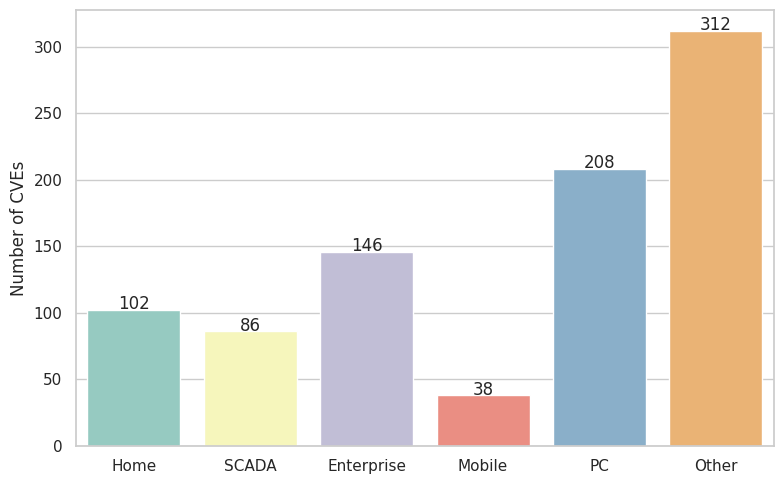

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Define colors for each bar
colors = sns.color_palette("Set3", len(dist_counts_vendor))

# Create barplot
ax = sns.barplot(
    data=dist_counts_vendor,
    x="IoT_Class",
    y="Count",
    order=dist_counts_vendor["IoT_Class"],  # keep the order
    palette=colors
)

# Add numbers on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,  # center of the bar
        y=height + 0.5,  # slightly above the bar
        s=f'{int(height)}',  # text to display
        ha='center'
    )

#plt.title("Number of CVEs per IoT Class")
#plt.xlabel("IoT Class")
ax.set_xlabel('')        # optional: remove the axis label
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('iot_cves_plot_des_ven_pro.pdf', format='pdf', bbox_inches='tight')
plt.show()


#### I can see that my prector has improved, by extracting the both the vendor and prodcut names from the CVE <br> But i still need better way to reduce the bios towards "Other" and some false positive

In [19]:
# ==================== SAVE FINAL DATASET AS CSV (SAFE) ====================
import pandas as pd
import csv

rows = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue

    desc = extract_description(cve)
    if not desc.strip():
        continue

    vendor, product = extract_vendor_product(cve)
    iot_class = enhanced_classify_cve(cve)

    rows.append({
        "id": json_file.stem,     # CVE ID
        "description": desc,      # FULL description (may contain newlines/tabs)
        "vendor": vendor,
        "product": product,
        "IoT_class": iot_class
    })

df = pd.DataFrame(rows)

# Optional but recommended: normalize whitespace for ML
df["description"] = df["description"].str.replace(r"\s+", " ", regex=True)

# SAFE CSV EXPORT (prevents column splitting)
df.to_csv(
    "cve_iot_dataset_update.csv",
    index=False,
    encoding="utf-8",
    quoting=csv.QUOTE_ALL,   # critical fix
    lineterminator="\n"     # <-- correct argument
)

print(f"Saved {len(df)} CVEs to cve_iot_dataset.csv")


Saved 892 CVEs to cve_iot_dataset.csv


## End or Rule-based
